In [1]:
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
import posteriors
import torchopt
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the data

First up, let's load the Pima Indians dataset, which consists of 768 samples of 8 feature variables and a binary target variable (class).

In [2]:
# Load the Pima Indians Diabetes dataset
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "num_pregnant",
    "glucose_concentration",
    "blood_pressure",
    "skin_thickness",
    "serum_insulin",
    "bmi",
    "diabetes_pedigree",
    "age",
    "class",
]
data = pd.read_csv(data_url, header=None, names=column_names)

print(data.shape)

data.head()

(768, 9)


,num_pregnant,glucose_concentration,blood_pressure,skin_thickness,serum_insulin,bmi,diabetes_pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Now we'll normalise the features and load it into PyTorch tensors.

In [3]:
# Preprocess the data
X_all = data.drop(columns=["class"]).values
y_all = data["class"].values

# Normalize the data
X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0)
X_all = (X_all - X_mean) / X_std

# Convert to torch tensors
X_all = torch.tensor(X_all, dtype=torch.float)
y_all = torch.tensor(y_all, dtype=torch.float)

num_data = X_all.shape[0]

# Define the model

We'll use a simple Bayesian logistic model $p(y = 1 | x) = \text{sigmoid}(x^T w)$, where $w \in \mathbb{R}^8$ is the weight vector and $x \in \mathbb{R}^8$ is vector containing the normalised features.

We'll use a normal prior on the weights $w \sim \mathcal{N}(0, 1)$ (note the rescaling to ensure we are normalized in the case we recieve a minibatch).

We'll use standard Pyro code to define the model.

In [4]:
def model(batch):
    X, y = batch

    batchsize = X.shape[0]

    # Define the priors
    w = pyro.sample(
        "w",
        dist.Normal(torch.zeros(X.shape[1]), scale=(num_data / batchsize) ** 0.5),
    )  # Scale to ensure the prior variance is 1 for all batch sizes

    # Define the logistic regression model
    logits = torch.matmul(X, w)
    y_pred = torch.sigmoid(logits)

    return pyro.sample("obs", dist.Bernoulli(y_pred), obs=y)

Then we can use `pyro.poutine` to convert the model into a log posterior function that can be passed to `posteriors`.

In [5]:
def log_posterior_normalized(params, batch):
    X, y = batch
    batchsize = X.shape[0]
    conditioned_model = pyro.condition(model, data={"w": params})
    model_trace = pyro.poutine.trace(conditioned_model).get_trace((X, y))
    log_joint = model_trace.log_prob_sum()
    return log_joint / batchsize, torch.tensor([])

Recall that `posteriors` recommends [log posteriors to be normalized by batchsize](https://normal-computing.github.io/posteriors/log_posteriors/) and return a tuple with [optional auxiliary information](https://normal-computing.github.io/posteriors/gotchas/#auxiliary-information).

# VI with `posteriors`

Now let's use `posteriors` to perform variational inference with the above data and model.

In [6]:
steps_vi = 8000
batchsize = 32
initial_params = torch.zeros(X_all.shape[1])

In [7]:
transform = posteriors.vi.diag.build(
    log_posterior_normalized, torchopt.adam(), temperature=1 / num_data
)

In [8]:
state = transform.init(initial_params)

In [9]:
nelbos = torch.zeros(steps_vi)

for i in tqdm(range(steps_vi)):
    batch_inds = torch.randint(num_data, (batchsize,))
    batch = (X_all[batch_inds], y_all[batch_inds])
    
    state = transform.update(state, batch)
    nelbos[i] = state.nelbo


100%|██████████| 8000/8000 [00:06<00:00, 1154.44it/s]


# Check convergence and plot marginals

Now let's examine our results!

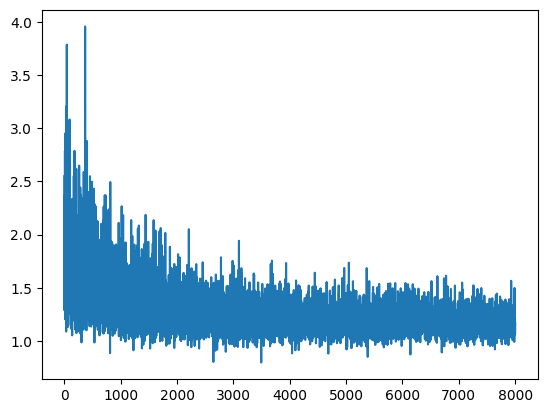

In [10]:
plt.plot(nelbos);

Seems to have converged!

Now let's examine the marginals of the weights.

In [11]:
state.log_sd_diag

tensor([-1.8832, -1.6376, -1.9421, -1.9521, -1.8949, -1.7948, -1.7865, -1.9213])

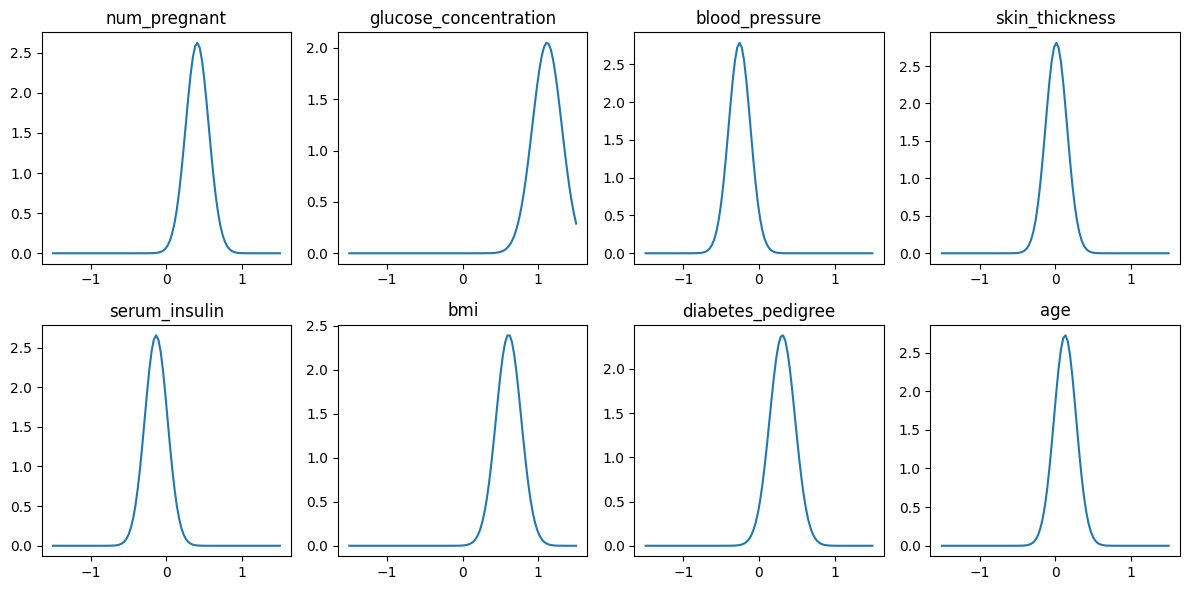

In [12]:
linspace = torch.linspace(-1.5, 1.5, 100)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    gauss_density_evals = dist.Normal(loc=state.params[i], scale=state.log_sd_diag[i].exp()).log_prob(linspace).exp()
    ax.plot(linspace.numpy(), gauss_density_evals.numpy())
    ax.set_title(column_names[i])
fig.tight_layout()


Looking good!